In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mping
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# Dataset Loading
if not os.path.exists("/content/drive/MyDrive/Infosys DataSet.zip"):
    raise FileNotFoundError("Dataset ZIP file not found at specified path.")

In [3]:
# Dataset
import zipfile
z = zipfile.ZipFile('/content/drive/MyDrive/Infosys DataSet.zip')
z.extractall()

Preprosesing


In [4]:
#Renaming
# Define the base folder path
base_folder = '/content/Infosys DataSet'

# Iterate through each subfolder (class) in the base folder
for class_name in os.listdir(base_folder):
    class_folder = os.path.join(base_folder, class_name)
    if os.path.isdir(class_folder):  # Ensure it's a directory
        print(f"Renaming images in folder: '{class_name}'")

        # Check if all files in the folder are already renamed
        all_renamed = True
        for filename in os.listdir(class_folder):
            if not filename.startswith(class_name + '_') or not filename.endswith('.jpg'):
                all_renamed = False
                break  # If any file is not renamed, we process the folder

        if all_renamed:
            print(f"All files in '{class_name}' are already renamed. Skipping folder...\n")
            continue  # Skip this folder

        # Rename images inside the folder
        print(f"Renaming files in: {class_folder}")
        count = 1
        for filename in os.listdir(class_folder):
            source = os.path.join(class_folder, filename)
            if os.path.isfile(source):  # Ensure it's a file
                # Create the new file name with class prefix and count
                destination = os.path.join(class_folder, f"{class_name}_{count}.jpg")
                os.rename(source, destination)
                count += 1

        # Display a message indicating all files have been renamed
        print(f"All images in folder '{class_name}' have been renamed successfully.\n")

    print(f"Folder '{class_name}' processing is complete.\n")


Renaming images in folder: 'Vijay'
Renaming files in: /content/Infosys DataSet/Vijay
All images in folder 'Vijay' have been renamed successfully.

Folder 'Vijay' processing is complete.

Renaming images in folder: 'Prabhas'
Renaming files in: /content/Infosys DataSet/Prabhas
All images in folder 'Prabhas' have been renamed successfully.

Folder 'Prabhas' processing is complete.

Renaming images in folder: 'Amitabh Bachan'
Renaming files in: /content/Infosys DataSet/Amitabh Bachan
All images in folder 'Amitabh Bachan' have been renamed successfully.

Folder 'Amitabh Bachan' processing is complete.

Renaming images in folder: 'Akshay Kumar'
Renaming files in: /content/Infosys DataSet/Akshay Kumar
All images in folder 'Akshay Kumar' have been renamed successfully.

Folder 'Akshay Kumar' processing is complete.



In [5]:
# EDA(Exploratory Data Analysis)
# Base directory containing subfolders with images
base_folder_path = '/content/Infosys DataSet'

# Get all subfolders (directories) inside the base folder
subfolders = [folder for folder in os.listdir(base_folder_path) if os.path.isdir(os.path.join(base_folder_path, folder))]

# Iterate through each subfolder and count the number of images
for folder in subfolders:
    folder_path = os.path.join(base_folder_path, folder)
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    number_of_images = len(image_files)
    print(f"Number of images in '{folder}' folder: {number_of_images}")


Number of images in 'Vijay' folder: 336
Number of images in 'Prabhas' folder: 288
Number of images in 'Amitabh Bachan' folder: 239
Number of images in 'Akshay Kumar' folder: 310


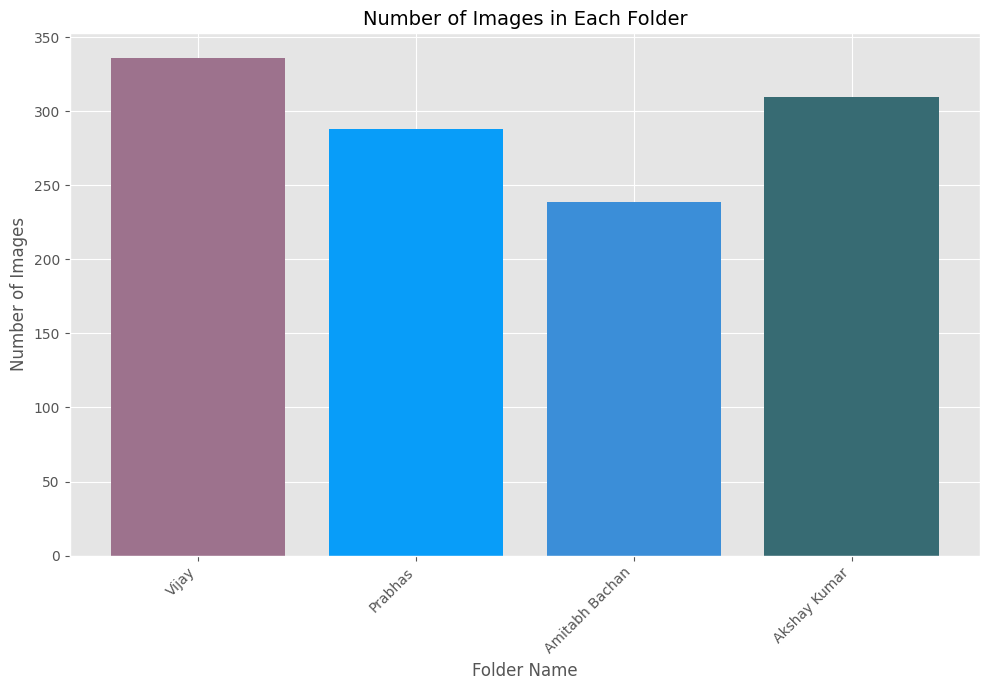

In [6]:
# Plotting
import random
# Path to the base directory containing subfolders
base_folder_path = "/content/Infosys DataSet"

# List all subfolders in the base folder
folders = [folder for folder in os.listdir(base_folder_path) if os.path.isdir(os.path.join(base_folder_path, folder))]

# Prepare data for plotting
folder_names = []
image_counts = []
colors = []

# Image file extensions
image_extensions = ('.jpg', '.jpeg', '.png')  # Update if needed

# Count images for each folder
for folder in folders:
    folder_path = os.path.join(base_folder_path, folder)
    num_images = sum(1 for file in os.listdir(folder_path) if file.endswith(image_extensions))

    folder_names.append(folder)
    image_counts.append(num_images)

    # Assign a random color for each folder for distinction
    colors.append((random.random(), random.random(), random.random()))  # RGB color tuple

# Plotting
fig = plt.figure(figsize=(10, 7))
plt.bar(folder_names, image_counts, color=colors)

plt.xlabel('Folder Name', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of Images in Each Folder', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to fit the labels

plt.show()


In [7]:
#Gray Scale Conversion display
# Define the dataset path
dataset_path = '/content/Infosys DataSet'

# Preprocessing function
def preprocess_image(image):
    # Resize the image to a fixed size (e.g., 128x128)
    resized_image = cv2.resize(image, (128, 128))

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization to improve contrast
    equalized_image = cv2.equalizeHist(gray_image)

    # Normalize the image to have pixel values between 0 and 1
    normalized_image = equalized_image / 255.0

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(normalized_image, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(np.uint8(blurred_image * 255), 100, 200)

    # Stack the grayscale, blurred, and edges as channels
    preprocessed_image = np.stack([normalized_image, blurred_image, edges], axis=-1)

    return preprocessed_image

# Dictionary to store preprocessed images by class
preprocessed_data = {}

# Process each subfolder (class)
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory
        print(f"Processing images for class: {class_name}")
        preprocessed_images = []

        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            if os.path.isfile(file_path):  # Ensure it's a file
                try:
                    # Read the image
                    image = cv2.imread(file_path, cv2.IMREAD_COLOR)
                    if image is not None:
                        # Apply preprocessing
                        preprocessed_image = preprocess_image(image)
                        preprocessed_images.append(preprocessed_image)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

        # Store preprocessed images for this class
        preprocessed_data[class_name] = np.array(preprocessed_images)
        print(f"Preprocessed {len(preprocessed_images)} images for class '{class_name}'.\n")

# Check the results
for class_name, images in preprocessed_data.items():
    print(f"Class '{class_name}': {len(images)} preprocessed images.")



Processing images for class: Vijay
Preprocessed 336 images for class 'Vijay'.

Processing images for class: Prabhas
Preprocessed 288 images for class 'Prabhas'.

Processing images for class: Amitabh Bachan
Preprocessed 239 images for class 'Amitabh Bachan'.

Processing images for class: Akshay Kumar
Preprocessed 310 images for class 'Akshay Kumar'.

Class 'Vijay': 336 preprocessed images.
Class 'Prabhas': 288 preprocessed images.
Class 'Amitabh Bachan': 239 preprocessed images.
Class 'Akshay Kumar': 310 preprocessed images.


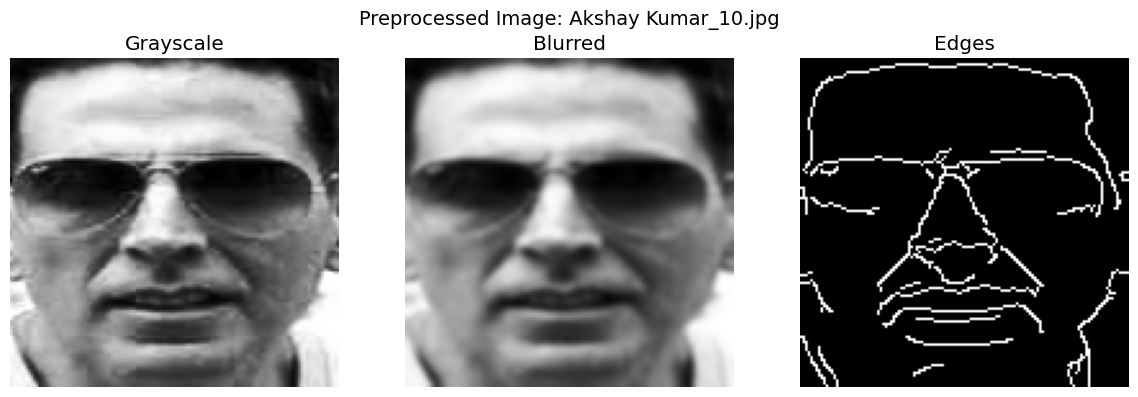

In [8]:
#Display
# Preprocessing function (same as in your dataset code)
def preprocess_image(image):
    resized_image = cv2.resize(image, (128, 128))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    equalized_image = cv2.equalizeHist(gray_image)
    normalized_image = equalized_image / 255.0
    blurred_image = cv2.GaussianBlur(normalized_image, (5, 5), 0)
    edges = cv2.Canny(np.uint8(blurred_image * 255), 100, 200)
    preprocessed_image = np.stack([normalized_image, blurred_image, edges], axis=-1)
    return preprocessed_image

def display_preprocessed_image_from_path(image_path):
    if not os.path.exists(image_path):
        print(f"Error: File not found at '{image_path}'.")
        return

    try:
        # Read the image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            print(f"Error: Unable to read the image at '{image_path}'.")
            return

        # Preprocess the image
        preprocessed_image = preprocess_image(image)

        # Plot the different channels
        plt.figure(figsize=(12, 4))

        # Grayscale channel
        plt.subplot(1, 3, 1)
        plt.imshow(preprocessed_image[:, :, 0], cmap='gray')
        plt.title("Grayscale")
        plt.axis('off')

        # Blurred channel
        plt.subplot(1, 3, 2)
        plt.imshow(preprocessed_image[:, :, 1], cmap='gray')
        plt.title("Blurred")
        plt.axis('off')

        # Edges channel
        plt.subplot(1, 3, 3)
        plt.imshow(preprocessed_image[:, :, 2], cmap='gray')
        plt.title("Edges")
        plt.axis('off')

        plt.suptitle(f"Preprocessed Image: {os.path.basename(image_path)}", fontsize=14)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while processing the image: {e}")

# Example usage
# Replace this path with any image path from your dataset
image_path = '/content/Infosys DataSet/Akshay Kumar/Akshay Kumar_10.jpg'
display_preprocessed_image_from_path(image_path)


In [9]:
#Cropping Image
def crop_and_normalize_image(image, plot=False):

    h, w, _ = image.shape
    crop_size = min(h, w)  # Square crop
    start_x = (w - crop_size) // 2
    start_y = (h - crop_size) // 2
    cropped_image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]
    resized_image = cv2.resize(cropped_image, (256, 256))  # Resize to target size
    normalized_image = resized_image / 255.0

    if plot:
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
        plt.title("Cropped and Resized Image")
        plt.axis('off')

        plt.show()

    return normalized_image


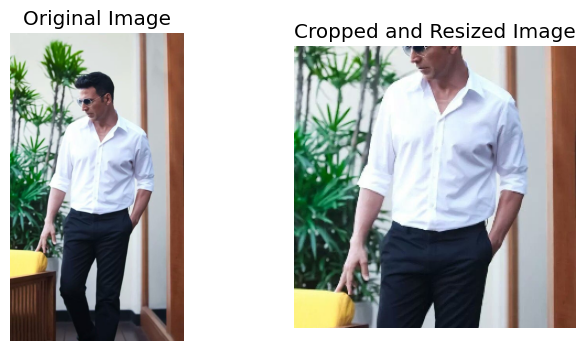

In [ ]:
image_path = '/content/Infosys DataSet/Akshay Kumar/Akshay Kumar_17.jpg'
if os.path.exists(image_path):
    image = cv2.imread(image_path)
    cropped_image = crop_and_normalize_image(image, plot=True)
else:
    print(f"Image not found at path: {image_path}")


Data Augumentation

In [11]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

# Paths for dataset and augmented data
base_folder = '/content/Infosys DataSet'  # Path to original dataset
augmented_data_path = '/content/augmented_dataset'  # Path to store both original and augmented images

# Create output directory if it doesn't exist
os.makedirs(augmented_data_path, exist_ok=True)

# Create ImageDataGenerator for augmentation
datagen = ImageDataGenerator(rotation_range=10,
                       width_shift_range=0.1,
                       height_shift_range=0.1,
                       shear_range=0.1,
                       brightness_range=(0.3, 1.0),
                       horizontal_flip=True,
                       vertical_flip=True,
                       fill_mode='nearest')

# Target image count per class
target_image_count = 500

# Iterate through each class (folder) in the dataset
for class_name in os.listdir(base_folder):
    class_path = os.path.join(base_folder, class_name)
    if os.path.isdir(class_path):  # Only process folders

        print(f"\nProcessing class: {class_name}")

        # Create a new directory for this class in the augmented dataset
        save_path = os.path.join(augmented_data_path, class_name)
        os.makedirs(save_path, exist_ok=True)

        # Copy original images to the new directory and prepare for augmentation
        images = []
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            if os.path.isfile(img_path):  # Ensure it's an image file
                # Copy original image to the augmented folder
                shutil.copy(img_path, save_path)

                # Read and preprocess the image for augmentation
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.resize(image, (224, 224))  # Resize to 224x224
                    images.append(image)

        # Count the number of original images
        num_original = len(images)
        print(f"Original images: {num_original}")

        # Calculate the number of augmented images needed
        needed_images = target_image_count - num_original

        if needed_images > 0:
            print(f"Augmenting {needed_images} images for class: {class_name}")

            # Convert images to numpy array and normalize them
            images_array = np.array(images).astype('float32') / 255.0

            # Generate augmented images
            total_generated = 0
            for batch in datagen.flow(images_array, batch_size=1, save_to_dir=save_path,
                                      save_prefix=class_name, save_format='jpg'):
                total_generated += 1
                if total_generated >= needed_images:
                    break
            print(f"Augmented images generated: {total_generated}")
        else:
            print(f"No augmentation needed for class: {class_name} (already has {num_original} images).")

print("\nData augmentation completed for all classes!")



Processing class: Vijay
Original images: 336
Augmenting 164 images for class: Vijay
Augmented images generated: 164

Processing class: Prabhas
Original images: 288
Augmenting 212 images for class: Prabhas
Augmented images generated: 212

Processing class: Amitabh Bachan
Original images: 239
Augmenting 261 images for class: Amitabh Bachan
Augmented images generated: 261

Processing class: Akshay Kumar
Original images: 310
Augmenting 190 images for class: Akshay Kumar
Augmented images generated: 190

Data augmentation completed for all classes!


In [12]:
# EDA(Exploratory Data Analysis)
base_folder_path = '/content/augmented_dataset'

# Get all subfolders (directories) inside the base folder
subfolders = [folder for folder in os.listdir(base_folder_path) if os.path.isdir(os.path.join(base_folder_path, folder))]

# Iterate through each subfolder and count the number of images
for folder in subfolders:
    folder_path = os.path.join(base_folder_path, folder)
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    number_of_images = len(image_files)
    print(f"Number of images in '{folder}' folder: {number_of_images}")



Number of images in 'Vijay' folder: 500
Number of images in 'Prabhas' folder: 500
Number of images in 'Amitabh Bachan' folder: 500
Number of images in 'Akshay Kumar' folder: 500


<ipython-input-13-668086ead8a1>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(folder_names, rotation=45, ha='right')


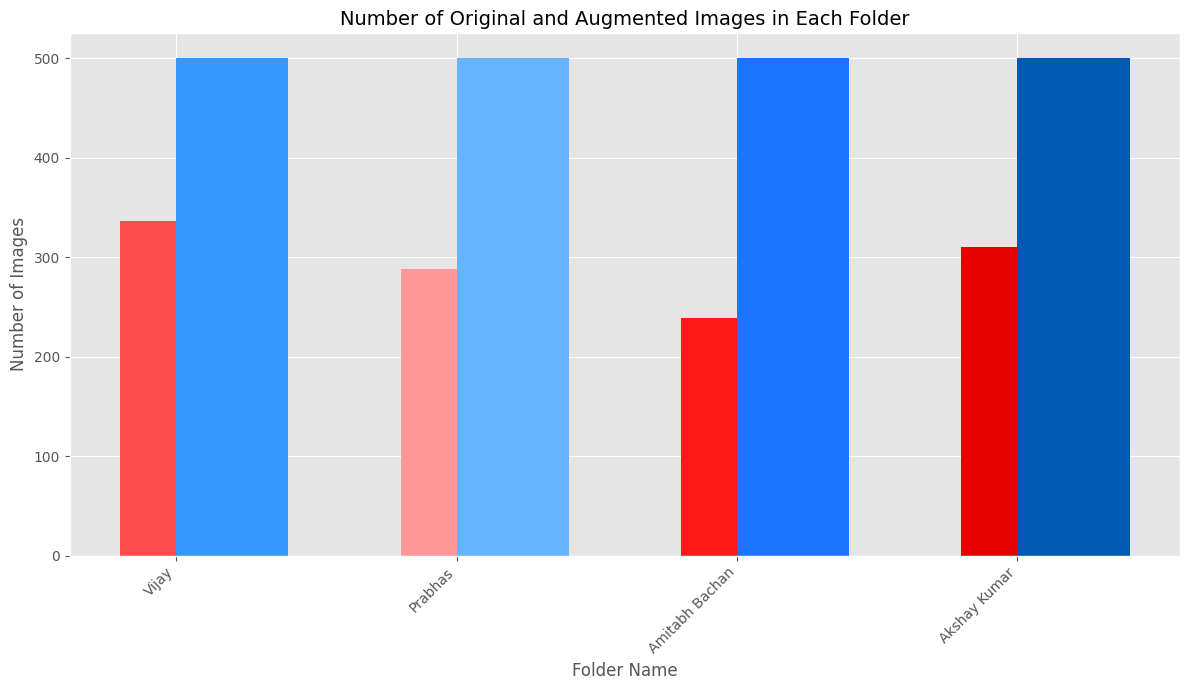

In [13]:
# Ploting
# Base directory paths for original and augmented images
original_base_folder_path = "/content/Infosys DataSet"
augmented_base_folder_path = "/content/augmented_dataset"

# List all subfolders in the original dataset base folder
original_folders = [folder for folder in os.listdir(original_base_folder_path) if os.path.isdir(os.path.join(original_base_folder_path, folder))]
augmented_folders = [folder for folder in os.listdir(augmented_base_folder_path) if os.path.isdir(os.path.join(augmented_base_folder_path, folder))]

# Prepare data for plotting
folder_names = []
image_counts_original = []
image_counts_augmented = []

# Image file extensions
image_extensions = ('.jpg', '.jpeg', '.png')  # Update if needed

# Count images for each folder in the original dataset
for folder in original_folders:
    original_folder_path = os.path.join(original_base_folder_path, folder)
    num_images_original = sum(1 for file in os.listdir(original_folder_path) if file.endswith(image_extensions))

    folder_names.append(folder)
    image_counts_original.append(num_images_original)

# Count images for each folder in the augmented dataset
for folder in augmented_folders:
    augmented_folder_path = os.path.join(augmented_base_folder_path, folder)
    num_images_augmented = sum(1 for file in os.listdir(augmented_folder_path) if file.endswith(image_extensions))

    image_counts_augmented.append(num_images_augmented)

# Create a color palette of shades of red and blue for alternating bars
colors_original = ['#ff4d4d', '#ff9999', '#ff1a1a', '#e60000', '#b30000']  # Shades of Red
colors_augmented = ['#3399ff', '#66b3ff', '#1a75ff', '#0059b3', '#0040b3']  # Shades of Blue

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the original dataset bars (shades of red)
for i, folder in enumerate(folder_names):
    ax.bar(folder, image_counts_original[i], width=0.4, color=colors_original[i % len(colors_original)], align='center')

# Plot the augmented dataset bars (shades of blue)
for i, folder in enumerate(folder_names):
    ax.bar(folder, image_counts_augmented[i], width=0.4, color=colors_augmented[i % len(colors_augmented)], align='edge')

# Labels and title
ax.set_xlabel('Folder Name', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Number of Original and Augmented Images in Each Folder', fontsize=14)

# Rotate x-axis labels for better visibility
ax.set_xticklabels(folder_names, rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to fit the labels

plt.show()


Model's Deployment

In [14]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the dataset directory
dataset_dir = '/content/augmented_dataset'

# Initialize lists to store image data and labels
image_data = []
labels = []
class_labels = {actor: idx for idx, actor in enumerate(os.listdir(dataset_dir))}  # actor -> label mapping

# Load images and corresponding labels
for actor in os.listdir(dataset_dir):
    actor_dir = os.path.join(dataset_dir, actor)

    if os.path.isdir(actor_dir):  # Only consider directories (for each actor)
        for img_name in os.listdir(actor_dir):
            img_path = os.path.join(actor_dir, img_name)

            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check if the file is an image
                img = image.load_img(img_path, target_size=(224, 224))  # Resize the image to match input shape
                img_array = image.img_to_array(img) / 255.0  # Normalize image
                image_data.append(img_array)
                labels.append(class_labels[actor])  # Assign label based on actor

# Convert lists to NumPy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Split the data into training (70%), validation (15%), and testing (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(image_data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Use `flow` method to create batches of data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1400
Validation set size: 300
Test set size: 300


In [15]:

# Path to your dataset directory
dataset_dir = '/content/Infosys DataSet'

# Dynamically get the list of celebrity names (folder names)
celebrity_names = [d.name for d in os.scandir(dataset_dir) if d.is_dir()]

# Print the list of celebrity names
print(celebrity_names)

['Vijay', 'Prabhas', 'Amitabh Bachan', 'Akshay Kumar']


In [28]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Define the CNN model
model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),

    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Global Average Pooling
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layer
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),

    # Additional Dense Layer
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 431,748 (1.65 MB)

 Trainable params: 430,788 (1.64 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
import os
import numpy as np
from PIL import Image

# Define the dataset directory
dataset_dir = '/content/augmented_dataset'  # Assuming you have a combined folder of original and augmented images

# Initialize lists to store image data and labels
X_train = []
y_train = []

# Get the class names (folder names)
celebrity_names = os.listdir(dataset_dir)

# Load and preprocess the data for all the images in the dataset
for name in celebrity_names:
    celebrity_folder = os.path.join(dataset_dir, name)

    # Check if it's a directory (class folder)
    if os.path.isdir(celebrity_folder):
        for img_path in os.listdir(celebrity_folder):
            # Get the full path to the image
            img_full_path = os.path.join(celebrity_folder, img_path)

            # Open the image and convert to RGB (to ensure consistency in channels)
            img = Image.open(img_full_path).convert('RGB')
            img = img.resize((64, 64))  # Resize image to (64, 64)

            # Convert the image to a numpy array and normalize
            img_array = np.array(img) / 255.0  # Normalize the image to [0, 1]

            # Append the image array and label (index of celebrity)
            X_train.append(img_array)
            y_train.append(celebrity_names.index(name))  # The label is the index of the celebrity

# Convert lists to numpy arrays
X_train = np.array(X_train, dtype=np.float32)  # Explicitly specify dtype for consistency
y_train = np.array(y_train, dtype=np.int32)  # Ensure labels are integers

# Print the size of the training set
print(f"Training set size: {X_train.shape[0]}")


Training set size: 2000


In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the size of the training and validation sets
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 1600
Validation set size: 400


In [19]:
X_train.shape

(1600, 64, 64, 3)

In [20]:
y_train.shape

(1600,)

In [29]:
from tensorflow.keras.models import Sequential

# Define the CNN model
model = Sequential()

# Input layer
model.add(layers.Input(shape=(64, 64, 3)))  # Resized images to 64x64, 3 color channels

# Convolutional Layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output to feed into Dense layers
model.add(layers.Flatten())

# Fully Connected (Dense) Layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization

# Output Layer
model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))  # Dynamic number of classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=8, validation_data=(X_val, y_val))

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.2777 - loss: 1.4030 - val_accuracy: 0.3250 - val_loss: 1.3543
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.3704 - loss: 1.3383 - val_accuracy: 0.3550 - val_loss: 1.3450
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.4069 - loss: 1.2980 - val_accuracy: 0.3975 - val_loss: 1.2415
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.4604 - loss: 1.2033 - val_accuracy: 0.4350 - val_loss: 1.1683
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.5301 - loss: 1.0781 - val_accuracy: 0.4375 - val_loss: 1.1895
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.5560 - loss: 1.0024 - val_accuracy: 0.4975 - val_loss: 1.1213
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.6033 - loss: 0.9049 - val_accuracy: 0.4925 - val_loss: 1.1807
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.5915 - loss: 0.8431 - 

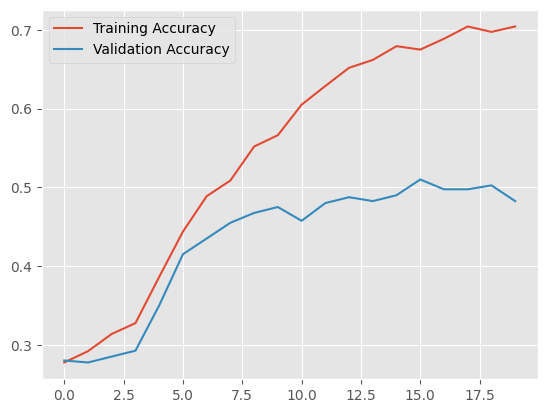

In [26]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()